# Training with Early stopping and n fold cross validation!

# Early Stopping regularization

Before reporting our taring strategy, we briefly define several terms, well known in the Deep learning community: one epoch is when the entire training dataset is passed forward and backward through the model. During forward pass, the model returns an output, which is then compared with the true label and a loss function measures the cost of their difference. During backwards pass, the weights of the model are updated via iterative optimizing algorithm, such as gradient decent, so as to decrease this loss. The optimizing algorithm has a parameter called learning rate, which determines the step size with which this weights are updated. Smaller learning rate results in a better convergence at the expense of longer learning time. Since we can’t pass all data at once, and sometimes we might not need to (if our data has many very similar data-points for example), the full training data is divided into smaller subsets, batches, each of which is passed forward and backward through the network one by one. The weights of the model are updated at every step so as to minimize the the loss of each batch. When we iterate through all batches, we have completed one epoch. When training neural networks with iterative optimizer, usually more than one epoch is needed for the model to converge. In our training process we used Adam optimizer and Binary Cross Entropy Loss.

Early stopping is a regularization technique that is used when there is an iterative learning process. Several variations of this technique exist, but the one we utilize aims to make the model a better fit to data outside of the training set, validation dataset.

Here we describe the way we employed early stopping regularization. After each epoch, the model under training was set to interference state and its performance was evaluated on a separate validation data set. The training data set and validation data set ware prodiced by n Flod Cross Validation technique. Each data set (training and validation) has equal ratio of 0 and 1 labels, the ratio of forested to deforested pixels labels, which was set to $\theta$ (times). At each epoch iteration, if the performance of the model on this validation data set was better than its performance in the previous iteration according to a certain criterion, the leering process continue to iterate through the batches one more time until new epoch is completed. If however, the performance on this iteration is worse, a counter variable starts counting how many times the updated model after each epoch is worse than the previously best one. That is, if the model gives tree times in a row, i+1, i+2, i+3, worse performance than the one recorded at iterations i, the counter has value 3. The counter counts up to pre-defined "waiting time" (patiance) and is reset to 0 each time a new, better performing model is found. In our training strategy we set the "weighting time" = patience to be 3. Which means that if our model performs three times in a row worse than it did at iteration i, then we stop the learning process, and chose the model with weights evaluated at iteration i. If the model however performs worse at iteration i+1 and i+2 than it did at i, but at i+3 it is better according to the criteria, the counting process restart and the model. The model at iteration i+4 is now compared with the previously best, i+3. 

The above described algorithm is general, and well known within DL community. The way we modified this algorithm is by re-sampling our taring and validation data sets after each epoch n-fold devision was completed. That is, if we have set 5 fold cross validation split, after the fifth fold, new 0 labels were added to the training data set and new 5 folda devision was then created. The addition of new 0 labels is performed by sampler.update(). We also investigated the effect of employing this Early Stopping technique with different criterions, namely Area Undrer the Area Under The Receiver Operating Characteristics (AUC), Weighted Binary Crossentropy Loss and the Cost from Cost matrix. As training time was an issue, we only run our algorithm up to 5 epochs, with "waiting time" 3 and the best performing model was returned. 

# Cost from Cost matrix

Since when training the model, we set the model class balance. Therefore we know the true ratio of 0:1 labels of the data. Collecting the model outputs and the true labels we know that exactly 1/(1+train_times)% of them are labaled as 1. A model return array of scores, each in [0,1] for each data point. Score = 1 indicationg complete confidance in having label 1 and socre = 0, complete confidance in lable = 0. A perfect model predicting the top scored 1/(1+train_times)% data points as having label 1 will have 0 error rate. To evaluate the model performance we do as follows: we chose the treshhold of the socre as the value of the 1/(1+train_times) percentile. Therefore 1/(1+train_times)% of the data polints have score >= trshold and are clasified as 1. We then evaluate the weighted error rate deifned as Cost = FP+w*FN/TP+FP+w*FN+TN. Cost of 0 is perfect model. w define how much more we penetalize the False Negative Rate than the False Positive Rate. Hit Rate is 1 - FN/(FN+TN) = 1 - False Negative Rate. 

The function below takes as inputs the true labels = targets, the model predictions = outputs, the weight we want to use for cost function = w, the percentile with which we choose treshhold = perc. Finaly sigmoid is a boolen variable indication if the output scores needs to be squashed by a sigmid function. The reason for them not being is because training with BCEloss implementation in pytorch combines a Sigmoid layer and the BCELoss in one single class:https://pytorch.org/docs/stable/nn.html#loss-functions This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability. 

AUC_CM() returns the AUC and cost

In [1]:
import sklearn as skl
def AUC_CM(targets, outputs, w, perc, sigmoid ):    
        ######################    
        #Reportnig the AUC ROC and Confussion Matrix 
        ######################
        if sigmoid :
            outputs  = Sigmoid(outputs)
            
        auc = skl.metrics.roc_auc_score(targets,outputs)
        tr = np.percentile(outputs, perc)
        matrix = skl.metrics.confusion_matrix(targets, (outputs > tr)*1)
        cost = (matrix[0,1] + w*matrix[1,0]) / (np.sum(matrix) + (w-1)*matrix[1,0])
        print("\tAUC :",auc)
        print("\tPred:  ","\t",0,"\t\t",1)
        print("\tTrue: 0","\t",matrix[0,0],"\t\t",matrix[0,1])
        print("\tTrue: 1","\t",matrix[1,0],"\t\t",matrix[1,1])       
        print("\tTrue Positive Rate ",matrix[1,1]/sum(matrix[1,:]))
        print("\tCost = FP+w*FN/TP+FP+w*FN+TN = %.4f (w = %d)"%(cost,w))
        print("\tTreshold %.4f when percentage of 0 predicted labels is %d"%(tr,perc))
        return auc, cost

# Early Stoping Implementation:

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience.
    validation loss can be BCEweighted loss, Cost or -AUC
    """
    def __init__(self, patience, path):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            path: where to save the best checkpoint, path must inlude the model name
        """
        self.patience = patience
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf        

    def __call__(self, val_loss, model, optimiser):
        
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimiser)
        
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimiser)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimiser):
        '''Saves model when validation loss decrease.'''
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
                
        torch.save({'model_state_dict': model.state_dict(),
                    'optimiser_state_dict': optimiser.state_dict(),
                    'loss': val_loss}, self.path)
        self.val_loss_min = val_loss

# Training Process

train_model() combine all our strategies we discussed so far.
Inputs are:


        Data - the full Data object
        model - model to be trained 
        sampler - training sampler of class ImbalancedDatasetUnderSampler
        criterion - the loss to be optimized
        optimiser - the optimiser 
        patience - waiting time for early stopping
        n_epochs 
        n_splits - the number n of n - folds when cross validation split
        batch_size 
        stop_batch : for debbuging: if not none , than at which bach index to exit epoch cycle  
        print_batch : the frequency at repoting training loss
        training_time : limit of training time. If after the certain epoch, the total time of running this function
                        is more than training_time, return the best model so far and exit the training.
        w, perc parameters for reporting AUC_CM() results
        FNcond : if to use Cost as Early stopping critera
        AUC: if to use -AUC as Early stopping critera
        job: unique id
        path: where to save models 

Returns:

        model : best model 
        avg_train_losses: average training loss of an epoch batches
        avg_valid_losses: average val loss after of an epoch batches 
        AUCs_train: AUC of each training epoch 
        AUCs_val: AUC of each val epoch 
        costs_train: cost of each training epoch 
        costs_val: cost of each val epoch 
        name: model unique name 

visualize() visuallize the bellow:
    
        avg_train_losses: average training loss of an epoch batches
        avg_valid_losses: average val loss after of an epoch batches 
        AUCs_train: AUC of each training epoch 
        AUCs_val: AUC of each val epoch 
        costs_train: cost of each training epoch 
        costs_val: cost of each val epoch 
        name: model unique name  
    


In [17]:
def train_model(Data, model, sampler, criterion, optimiser, patience = 3, n_epochs = 5, n_splits= 5, batch_size = 50,
                    stop_batch = None , print_batch = 50 , training_time = 12,
                    w = 10, perc = 80, FNcond = True, AUC = False,
                    job = 1, path = "/rdsgpfs/general/user/kpp15/home/Hansen/deforestation_forecasting/models"): 
    
    #############################################
    # Set up the variables to track the trainig #
    #############################################
    t_start = time.time()
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    model = model.to(device)
    
    require_sigmoid = isinstance(criterion,torch.nn.modules.loss.BCEWithLogitsLoss)   
    
    # to track the training losses as the model trains and validate on each epoch
    train_losses = []
    valid_losses = []
    
    # to track the average losses as the model trains and validate per epoch
    avg_train_losses = []
    avg_valid_losses = [] 
    
    # to track the probabilities the model give on the train and validate data on each epoch
    train_outputs = []
    val_outputs = []
    
    # to track the true labels of the inputs when model trains and validate on each epoch
    train_targets = []
    val_targets = []
    
    # to track the cost as the model trains and validate on each epoch
    costs_train = []
    costs_val = []
    
    # to track the AUC as the model trains and validate on each epoch
    AUCs_train = []
    AUCs_val = []
    
    # initialize unique model name
    d = datetime.datetime.now()
    print("\nDate:",d)
    model_type = str(type(model))[8:-2]
    name = (str(type(model))[8:-2] + f'_{job :d}'+ f'j_{d.day:d}'+ f'.{d.month:d}'+ f'.{str(d.year)[-2:]}'+
                f'_{d.hour:d}'+ f'.{d.minute:d}'+ f'.{d.second:d}' + ".pt")
    path = os.path.join(path,model_type,name)
    print("\nCheckpoint saved at:",path)
    
    early_stopping = EarlyStopping(patience=patience, path=path)
    skf = StratifiedKFold(n_splits = n_splits)
    ls = list(skf.split(sampler.classIndexes_unsampled,
                                           Data.labels[sampler.classIndexes_unsampled]))
    "\nStart trainig..."
    ##############################
    # Start tracking the trainig #
    ############################## 
    
    
    for epoch in range(0,n_epochs):
        fold = epoch%n_splits
        epoch = epoch+1
        tr, val = ls[fold]
        tr_idx = sampler.classIndexes_unsampled[tr]
        val_idx = sampler.classIndexes_unsampled[val]
        print("\n\nEpoch %d, Fold %d Train size %d; Val size %d"%(epoch,fold+1,len(tr_idx),len(val_idx)))
      
        train_Sampler = SubsetRandomSampler(tr_idx)
        val_Sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(Data, sampler = train_Sampler, batch_size=batch_size)
        val_loader = DataLoader(Data, sampler = val_Sampler, batch_size=batch_size)   
      
        ###################
        # train the model #
        ###################
        model.train()       
        train_start = time.time()
        print("\n\tLearning:...")
        for batch, (data, target, cor) in enumerate(train_loader, 1): 
            
            if type(data) == type([]):              
                data[0] = data[0].to(device)
                data[1] = data[1].to(device)
            else:   
                data = data.to(device)    
            target = target.to(device)
            cor = cor.to(device)
            
            optimiser.zero_grad()          
            output = model.forward(data, sigmoid = not require_sigmoid)    
            loss = criterion(output, target.float())           
            loss.backward()            
            optimiser.step()
            # record training loss, predictions and targets
            train_losses.append(loss.cpu().item())
            train_outputs.append(list(output.cpu().data))
            train_targets.append(list(target.cpu().data))
            # =============================================================================
            if stop_batch:
                if batch == stop_batch:
                    break
            # =============================================================================
            if print_batch:
                if batch % print_batch == 0:
                    print('\tEpoch:', epoch, '\tBatch:', batch, '\tTraining Loss:', loss.item())
            # =============================================================================                    
        train_outputs = sum(train_outputs, [])
        train_targets = sum(train_targets, [])
        print("\tStop learning")
        t_time = time.time() - train_start  
        print("\n\tTime to load %d train batches of size %d : %3.4f hours "%(batch,batch_size,t_time/(3600)))


        #####################################
        #Report AUC and the CM on Train data#
        #####################################
        print("\n\tAUC and CM on Train data")
        auc_t, cost_train = AUC_CM(train_targets, train_outputs, w, perc, sigmoid = require_sigmoid )

        
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        val_start = time.time()       
        for batch, (data, target, cor) in enumerate(val_loader, 1):
            
            if type(data) == type([]):              
                data[0] = data[0].to(device)
                data[1] = data[1].to(device)
            else:   
                data = data.to(device)
            target = target.to(device)
            cor = cor.to(device)
            
            output = model.forward(data, sigmoid = not require_sigmoid )
            loss = criterion(output, target.float())
            valid_losses.append(loss.cpu().item())
            val_outputs.append(list(output.cpu().data))
            val_targets.append(list(target.cpu().data))
            # =============================================================================
            if stop_batch:
                if batch == stop_batch:
                    break          
            # =============================================================================
        val_outputs = sum(val_outputs , [])
        val_targets = sum(val_targets, [])
        v_time = time.time() - val_start  
        print("\n\tTime to load %d val batches of size %d : %3.4f hours "%(batch,batch_size,v_time/(3600)))
    
        ###############################     
        #Report AUC and CM on Val data#
        ###############################
        print("\tAUC and CM on Val data")
        auc_v, cost_val = AUC_CM(val_targets, val_outputs, w, perc, sigmoid = require_sigmoid )


        #Save results of the epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        costs_train.append(cost_train)
        costs_val.append(cost_val)
        AUCs_train.append(auc_t)
        AUCs_val.append(auc_v)
                              
        # clear lists to track next epoch
        train_losses = []
        train_targets = []
        train_outputs = []
        
        valid_losses = []
        val_outputs = []
        val_targets = []

               
        #print epoch summary
        epoch_len = len(str(n_epochs))               
        time_mid = time.time()
        total_time = time_mid - t_start
        total_time = total_time/3600
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}' + 
                     "\n" +
                     f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f' train AUC: {auc_t:3.5f}' + 
                     f' val AUC: {auc_v:3.5f}' + 
                     "\n" +
                     f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f' train cost: {cost_train:.5f}' + 
                     f' val cost: {cost_val:.5f}' + 
                     "\n" +
                     f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f' hours needed: {total_time: 4.4f}')        
        print("\n\nEpoch summary: ")
        print(print_msg)

        
        #Chech early stopping criteria
        # early_stopping needs the validation loss/Weighted error loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        if AUC:
            early_stopping(-auc_v, model, optimiser)
        elif FNcond:
            early_stopping(cost_val, model, optimiser)
        else:
            early_stopping(valid_loss, model, optimiser)
        
        if early_stopping.early_stop:
            print("\nEarly stopping!")
            break
         
        #Check total training time to here
        if total_time > training_time:
            print("\nTime exceeded!")
            break
        
        #Check if all flods are passed
        if fold == n_splits - 1:
            print("Folds exceeded. Adding new 0 labels...")
            sampler.update()
            ls = list(skf.split(sampler.classIndexes_unsampled,
                                           Data.labels[sampler.classIndexes_unsampled]))
            print("New 0 labels added!")
                     
    #load the last checkpoint with the best model
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
  
    return  model, avg_train_losses, avg_valid_losses, AUCs_train, AUCs_val ,costs_train, costs_val, name[:-3]

In [18]:
def visualize(train, valid, name, modelname, best = "min", path = "/rdsgpfs/general/user/kpp15/home/Hansen/deforestation_forecasting/models/pics"):
    print("\nReporting",name,"when training")
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train)+1), train, label='Training ' + name)
    plt.plot(range(1,len(valid)+1), valid, label='Validation ' + name)
    
    # find position of lowest validation loss
    if best == "min":
        bestposs = valid.index(min(valid))+1 
    else:    
        bestposs = valid.index(max(valid))+1
        
    plt.axvline(bestposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    plt.title( modelname+"_"+name+".png" )
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.xlim(0, len(train)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    path = os.path.join(path,modelname+"_"+name+".png")
    print("Figure saved at:",path)
    fig.savefig(path, bbox_inches='tight')

# Example

In [19]:
%cd /home/ubuntu/satellite/deforestation_forecasting/python_code
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from Data_maker_loader import *
from ConvRNN import *
from Training import ImbalancedDatasetUnderSampler
import sklearn as skld
from scipy.special import expit as Sigmoid
import scikitplot
import matplotlib.pyplot as plt
import time
import datetime
import os
sourcepath = '/home/ubuntu/satellite/data/raster/MadreTiff'
wherepath = '/home/ubuntu/satellite/data/raster/tensors'
modelpath = "/home/ubuntu/satellite/deforestation_forecasting/models"
picspath = "/home/ubuntu/satellite/deforestation_forecasting/models/pics"

/home/ubuntu/satellite/deforestation_forecasting/python_code


In [20]:
start_year = 14
end_year = 16

#set image parameeters
size = 45
#set model parameeters for 3D_CNN
input_dim= (2,8)
hidden_dim=(16,32,32)
kernel_size=((5,5),(2,5,5),(5,5))
levels=(10,)
dropout = 0.3

#set lerarinig parameeters
train_times = 4
test_times = 4
FNcond = True 
w = 10
perc = 80
AUC = False
BCE_Wloss = False
pos_weight = 3
lr = 0.0001 
weight_decay = 0    
batch_size = 10
n_epochs = 7
n_splits = 5
patience = 7

training_time = 7
stop_batch = 4
print_batch = 2

job = 2 

See ImbalancedDatasetUnderSampler for more detailed explanation of loading and undersampling data

In [7]:
Data = load_RNNdata(size = int(np.floor(size/2)) , start_year = start_year , end_year = end_year, path = wherepath)

In [8]:
if not (os.path.isfile(wherepath+"/"+"Train_idx%d.npy"%(end_year)) & os.path.isfile(wherepath+"/"+"Test_idx%d.npy"%(end_year))):
    print("Creating indexes split")
    train_idx, test_idx = train_test_split(np.arange(len(Data.labels)),
                                            test_size=0.2, random_state=42, shuffle=True, stratify=Data.labels)
    np.save(wherepath+"Train_idx%d.npy"%(end_year),train_idx)
    np.save(wherepath+"Test_idx%d.npy"%(end_year),test_idx)
else:
    train_idx = np.load(wherepath+"/"+"Train_idx%d.npy"%(end_year))
    test_idx = np.load(wherepath+"/"+"Test_idx%d.npy"%(end_year)) 

In [9]:
train_sampler = ImbalancedDatasetUnderSampler(labels = Data.labels, indices=train_idx, times = train_times)
test_sampler = ImbalancedDatasetUnderSampler(labels = Data.labels, indices=test_idx, times = test_times)
print("% deforested pixels in train:",train_sampler.count[1]/sum(train_sampler.count))
print("% deforested pixels in val:",test_sampler.count[1]/sum(test_sampler.count))

% deforested pixels in train: 0.0031246870449185365
% deforested pixels in val: 0.0031246637893983273


In [21]:
model = Conv_3D(
    input_dim = input_dim,
    hidden_dim = hidden_dim,
    kernel_size= kernel_size,
    levels=levels,
    dropout = dropout)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean', pos_weight = torch.tensor(3))
optimiser = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=0.)

In [22]:
#Print Summary of the training parameters
# =========================================================================    
print("Model:",str(type(model))[8:-2],"Period 20%d-20%d -> 20%d"%(start_year,end_year,end_year+1))   
print("Job: ",job)   
print("\nHyperparameters: ")
print("\tImage size: %d"%(size))
print("\tHidden dim: ",hidden_dim)
print("\tTrain and Test ratios of 0:1 labels: 1:%d ; 1:%d "%(train_times, test_times))
print("\tADAM optimizer parameters: lr=%.7f, weight decay=%.2f, batch size=%d"%(lr,weight_decay,batch_size))
print("\tBCEWithLogitsLoss pos_weights = %.2f"%(pos_weight))
print("\tn_epochs = %d with patience of %d epochs"%(n_epochs,patience))
print("\tCross Validation with n_splits = %d "%(n_splits))
print("\tIf to use BCEWithLogitsLoss as an early stop criterion :",((not AUC)&(not FNcond)))
print("\tIf to use AUC as an early stop criterion :",AUC)
print("\tIf to use cost = FP+w*FN / TP+FP+w*FN+TN as an early stop criterion")
print("\twith w = %d and treshhold = the %d percentile of the output"%(w,perc),FNcond)
print("\nModel: \n",model)
print("\nCriterion: \n",criterion)
print("\nOptimiser: \n",optimiser)

Model: ConvRNN.Conv_3D Period 2014-2016 -> 2017
Job:  2

Hyperparameters: 
	Image size: 45
	Hidden dim:  (16, 32, 32)
	Train and Test ratios of 0:1 labels: 1:4 ; 1:4 
	ADAM optimizer parameters: lr=0.0001000, weight decay=0.00, batch size=10
	BCEWithLogitsLoss pos_weights = 3.00
	n_epochs = 7 with patience of 7 epochs
	Cross Validation with n_splits = 5 
	If to use BCEWithLogitsLoss as an early stop criterion : False
	If to use AUC as an early stop criterion : False
	If to use cost = FP+w*FN / TP+FP+w*FN+TN as an early stop criterion
	with w = 10 and treshhold = the 80 percentile of the output True

Model: 
 Conv_3D(
  (conv_2D): Sequential(
    (0): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_3D): Sequen

In [23]:
model, train_loss, valid_loss, AUCs_train, AUCs_val ,costs_train, costs_val, name = train_model(Data = Data,
            model = model,
            sampler = train_sampler,
            criterion = criterion,
            optimiser = optimiser,
            patience = patience,
            n_epochs = n_epochs,
            n_splits = n_splits,                                                                                    
            batch_size = batch_size,
            stop_batch = stop_batch,
            print_batch = print_batch,
            training_time = training_time,
            w = w,
            perc = perc,
            FNcond = FNcond,
            AUC = AUC,
            job = job,
            path = modelpath)


Date: 2019-07-02 17:40:53.667512

Checkpoint saved at: /home/ubuntu/satellite/deforestation_forecasting/models/ConvRNN.Conv_3D/ConvRNN.Conv_3D_2j_2.7.19_17.40.53.pt


Epoch 1, Fold 1 Train size 1079943; Val size 269987

	Learning:...
	Epoch: 1 	Batch: 2 	Training Loss: 1.0634225606918335
	Stop learning

	Time to load 4 train batches of size 10 : 0.0001 hours 

	AUC and CM on Train data
	AUC : 0.4086021505376344
	Pred:   	 0 		 1
	True: 0 	 26 		 5
	True: 1 	 6 		 3
	True Positive Rate  0.3333333333333333
	Cost = FP+w*FN/TP+FP+w*FN+TN = 0.6915 (w = 10)
	Treshold 0.5545 when percentage of 0 predicted labels is 80

	Time to load 4 val batches of size 10 : 0.0000 hours 
	AUC and CM on Val data
	AUC : 0.20703125
	Pred:   	 0 		 1
	True: 0 	 31 		 1
	True: 1 	 8 		 0
	True Positive Rate  0.0
	Cost = FP+w*FN/TP+FP+w*FN+TN = 0.7232 (w = 10)
	Treshold 0.5224 when percentage of 0 predicted labels is 80


Epoch summary: 
[1/7] train_loss: 1.04092 valid_loss: 0.98077
[1/7]  train AUC: 0.40860 val


Reporting BCEloss when training


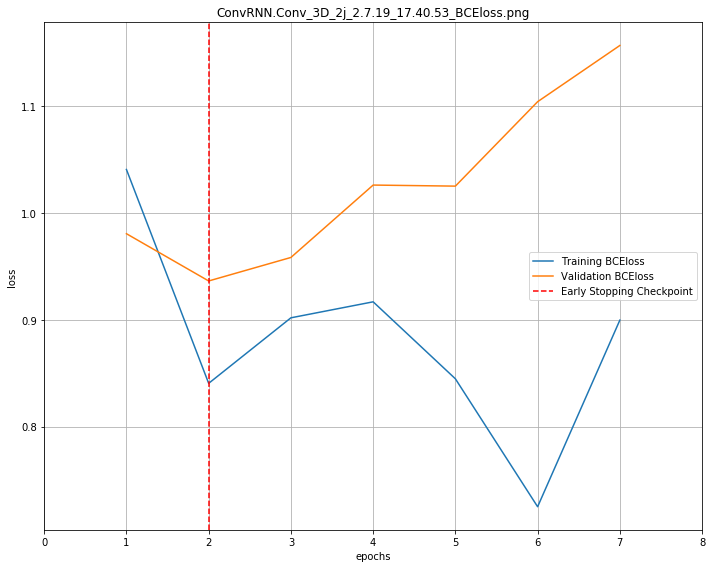

Figure saved at: /home/ubuntu/satellite/deforestation_forecasting/models/pics/ConvRNN.Conv_3D_2j_2.7.19_17.40.53_BCEloss.png

Reporting AUC when training


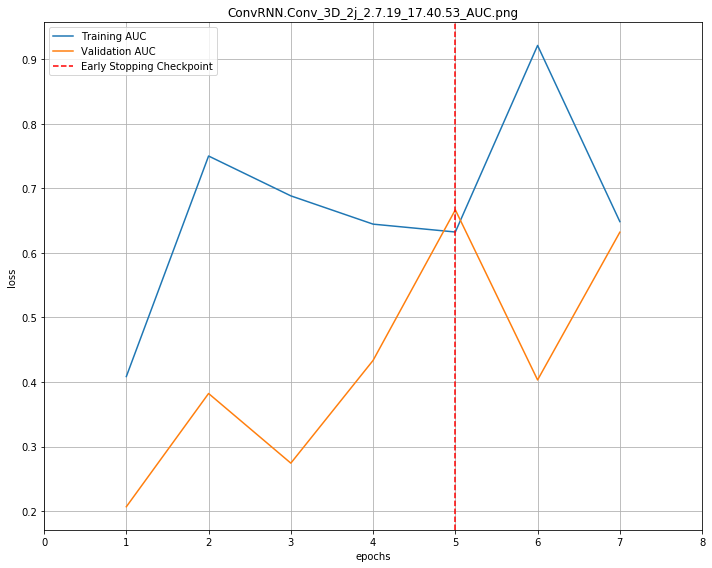

Figure saved at: /home/ubuntu/satellite/deforestation_forecasting/models/pics/ConvRNN.Conv_3D_2j_2.7.19_17.40.53_AUC.png

Reporting Cost when training


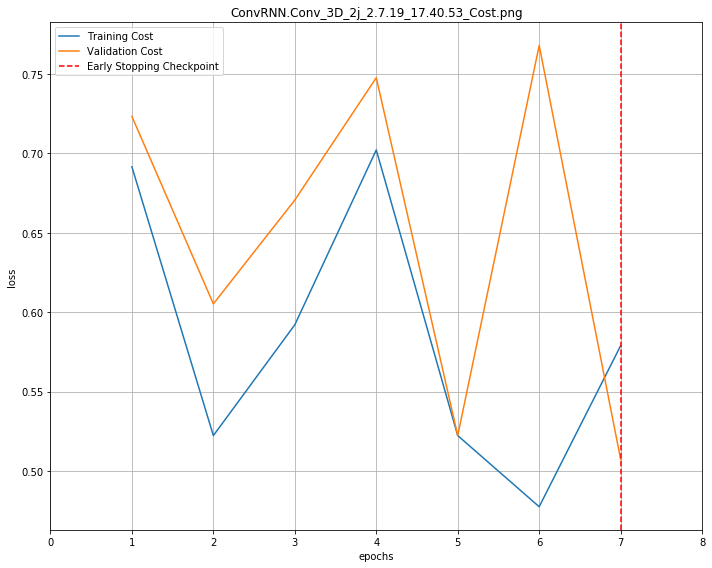

Figure saved at: /home/ubuntu/satellite/deforestation_forecasting/models/pics/ConvRNN.Conv_3D_2j_2.7.19_17.40.53_Cost.png


In [24]:
visualize(train = train_loss, valid = valid_loss, name = "BCEloss",
          modelname = name, best = "min", path = picspath)
visualize(train = AUCs_train, valid = AUCs_val, name = "AUC",
          modelname = name, best = "max", path = picspath)
visualize(train = costs_train, valid = costs_val, name = "Cost",
          modelname = name, best = "min", path = picspath)


Performance on test
	Test Loss:  1.1554620027542115
	AUC : 0.6991869918699187
	Pred:   	 0 		 1
	True: 0 	 34 		 7
	True: 1 	 6 		 3
	True Positive Rate  0.3333333333333333
	Cost = FP+w*FN/TP+FP+w*FN+TN = 0.6442 (w = 10)
	Treshold 0.6903 when percentage of 0 predicted labels is 80


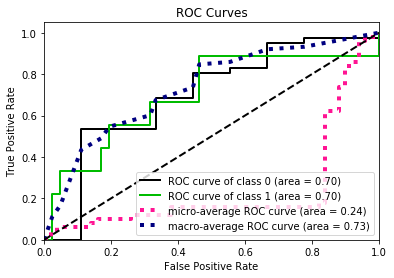

In [25]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = model.to(device)

# Performance on test   
# =============================================================================
# initialize lists to monitor test loss and accuracy
print("\nPerformance on test")
Test_sampler = SubsetRandomSampler(test_sampler.classIndexes_unsampled)
test_loader = DataLoader(Data, sampler = Test_sampler, batch_size=batch_size)

test_losses = []
output_total = []
target_total = []
model.eval() # prep model for evaluation

require_sigmoid = isinstance(criterion,torch.nn.modules.loss.BCEWithLogitsLoss)

for batch, (data, target, cor) in enumerate(test_loader):
    
    if type(data) == type([]):              
        data[0] = data[0].to(device)
        data[1] = data[1].to(device)
    else:   
        data = data.to(device)
    target = target.to(device)
    cor = cor.to(device)
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model.forward(data, sigmoid = not require_sigmoid)        
    # calculate the loss
    loss = criterion(output, target.float())
    test_losses.append(loss.item())
    output_total.append(list(output.cpu().data))
    target_total.append(list(target.cpu().data))
    # =====================================================================
    if stop_batch:
        if batch == stop_batch:
            break          
    # =====================================================================
output_total = sum(output_total, [])
target_total = sum(target_total, [])
test_losses = np.average(test_losses)
print('\tTest Loss: ',test_losses)
test_AUC , test_cost = AUC_CM(target_total, output_total, w, perc, sigmoid = require_sigmoid)
output_total = np.array(Sigmoid(output_total))
probas_per_class = np.stack((1 - output_total,output_total),axis = 1)
roc = scikitplot.metrics.plot_roc(np.array(target_total),probas_per_class)
path = os.path.join(picspath,name+"_ROC.png")
roc.get_figure().savefig(path, bbox_inches='tight')

In [28]:
job = 2
best_epoch = costs_val.index(min(costs_val))
summary = f'| Job:{job:d}'+' | Model:'+name+f' | Best epoch:{best_epoch+1:d} |'
Train = f'| Train loss:{train_loss[best_epoch]:.3f} | Train AUC:{AUCs_train[best_epoch]:.3f} | Train cost:{costs_train[best_epoch]:.3f} |'
Val = f'|   Val loss:{valid_loss[best_epoch]:.3f} |   Val AUC:{AUCs_val[best_epoch]:.3f} |   Val cost:{costs_val[best_epoch]:.3f} |' 
Test = f'|  Test loss:{test_losses:.3f} |  Test AUC:{test_AUC:.3f} |  Test cost:{test_cost:.3f} |'
print(summary)
print(Train)
print(Val)
print(Test)
file = open("/home/ubuntu/satellite/deforestation_forecasting/models/grid_summary/3DCNN.txt","a") 
file.write("\n\n")
file.write(summary)
file.write("\n")
file.write(Train) 
file.write("\n")
file.write(Val)
file.write("\n")
file.write(Test) 
file.write("\n")
file.close() 

| Job:2 | Model:ConvRNN.Conv_3D_2j_2.7.19_17.40.53 | Best epoch:7 |
| Train loss:0.900 | Train AUC:0.648 | Train cost:0.579 |
|   Val loss:1.157 |   Val AUC:0.632 |   Val cost:0.507 |
|  Test loss:1.155 |  Test AUC:0.699 |  Test cost:0.644 |


# To run several jobs when setting models parameters do:

In [ ]:
job = int(os.environ['PBS_ARRAY_INDEX']) 

if job == 2:
    kernel_size=((3,3),(2,3,3),(3,3))
    print("\nJob:",job, "parm selected:", kernel_size)

if job == 3:
    hidden_dim=(32,32,32)
    print("\nJob:",job, "parm selected:", hidden_dim)

if job == 4:
    levels=(10,5)
    print("\nJob:",job, "parm selected:", levels)

if job == 6:
    size = 35 
    print("\nJob:",job, "parm selected:", size )

if job == 7:
    size = 55
    print("\nJob:",job, "parm selected:", size )

if job == 8:
    w = 5
    print("\nJob:",job, "parm selected:", w )

if job == 9:
    pos_weight = 10
    print("\nJob:",job, "parm selected: ", pos_weight)

if job == 10:
    pos_weight = 15
    print("\nJob:",job, "parm selected: ", pos_weight)

if job == 11:
    weight_decay = 0.6
    print("\nJob:",job, "parm selected: ", weight_decay)

if job == 12:
    lr = 0.001 
    print("\nJob:",job, "parm selected:", lr)

## Submit: qsub 3DCNN.pbs

In [29]:
#             #PBS -l walltime=20:00:00
#             #PBS -l select=1:ncpus=1:mem=50gb
#             #PBS -J 1-12

#             module load anaconda3/personal
#             source activate py37

#             cd $PBS_O_WORKDIR
#             cd ../

#             python 3DCNN_train.py > txt_outputs/3DCNN/3DCNN.$PBS_ARRAY_INDEX

# To contine trainig models with same or new images (transfer learning) or and make predictions see continue_training
